# Contents

- [1. Simple Michelson Interferometer](#chap_1)
- [2. Simple Michelson Interferometer with phase modulator](#chap_2)
    - [2.1 Optimize demodulation phase such that differential arm length change appears only at Asymmetric port quadrature signal](#chap_2_1)
    - [2.2 Optimize Schnupp Asymmetry for maximizing quadrature signal at asymmetric port](#chap_2_2)
- [3. Power Recycled Michelson](#chap_3)
    - [3.1 Optimize Power Recycled Cavity length for sidebands to resonate](#chap_3_1)
    - [3.2 Optimize demodulation phase such that difference in arm length arrives at quadrature of asymmetric port](#chap_3_2)
    - [3.3 Optimize Schnupp asymmetry for a given R of PRM](#chap_3_3)
    - [3.4 Optimize demodulation phase of REFL_I, REFL_Q](#chap_3_4)
    - [3.5 Plots of all singals due to DARM (due to differential arm length change)](#chap_3_5)
    - [3.6 Plots of all signals due to CARM (common mode arm length change)](#chap_3_6)
    - [3.7 Sensing Matrix for PRMI with single phase modulator](#chap_3_7)
    - [3.8 Reflected and circulating feild amplitude variations due to CARM](#chap_3_8)



In [1]:
#%matplotlib notebook
from pykat import finesse
from pykat.commands import *
import pykat.external.peakdetect as peak
import pykat.ifo.aligo as aligo
import pykat.ifo.aligo.plot as aligoplt
#import pykat
import gwinc as gwinc

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

pykat.init_pykat_plotting(dpi=96)

#for animations:
from matplotlib import animation, rc
from IPython.display import HTML
#plt.style.use('dark_background')
# Update the matplotlib configuration parameters:
plt.rcParams.update({'text.usetex': False,
                     'lines.linewidth': 2,
                     #'font.family': 'serif',
                     #'font.serif': 'noto',
                     'font.size': 11,
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small',
                     'axes.labelsize': 'medium',
                     'axes.titlesize': 'medium',
                     'axes.grid.axis': 'both',
                     'axes.grid.which': 'both',
                     'axes.grid': True,
                     'grid.color': 'xkcd:gray',
                     'grid.alpha': 0.3,
                     'lines.markersize': 12,
                     'legend.borderpad': 0.2,
                     'legend.fancybox': True,
                     'legend.fontsize': 'small',
                     'legend.framealpha': 0.8,
                     'legend.handletextpad': 0.5,
                     'legend.labelspacing': 0.33,
                     'legend.loc': 'best',
                     'figure.figsize': ((7, 4)),
                     'savefig.dpi': 300,
                     'savefig.bbox': 'tight',
                     'pdf.compression': 9})


def radar_plot(self, detector_I, detector_Q, DOFs=None, ax=None, title=None, leg=True, autoscale=True):
    """Generates an I-Q quadrature radar plot from this sensing matrix.
    
    Each radar plot shows the magnitude and phase of the response in that
    sensor for each of the DOFs. e.g. Watts in POP_f1 per meter of ETMX motion
                    
    Parameters
    ----------
    detector_I : str
        Detector name in the sensing matrix for I quadrature
        
    detector_Q : str
        Detector name in the sensing matrix for Q quadrature
        
    DOFs : collection[str], optional
        DOFs in the sensing matrix to plot
    
    ax : axis, optional
        Matplotlib axis to put plot into
        
    title: str, optional
        Title of plot
    """
    
    I = self[detector_I]
    Q = self[detector_Q]
    
    A = I + 1j*Q
    
    # FFS, we need to standardize on the colors for the DOFs with an iron fist
    # DARM = DODGER BLUE, CARM = CARNATION, PRCL=PURPLE, MICH = MIDNIGHT, SRCL = Cyan
    clrs = ['xkcd:Dodger Blue', 'xkcd:Red', 'xkcd:Lavender', 'xkcd:Cyan', 'xkcd:Grey']
    
    _ax = ax or plt.subplot(111, projection='polar')
    _ax.set_theta_zero_location('E')
    r_lim = (np.log10(np.abs(A)).min()-1, np.log10(np.abs(A)).max())
    
    if DOFs and any((_ not in A.keys() for _ in DOFs)):
        raise Exception("Sensing matrix is missing one of DOFs ({0}) requested".format(DOFs))
        
    if DOFs:
        keys = tuple(_ for _ in A.keys() if _ in DOFs)
    else:
        keys = A.keys()
        
    scaling = np.linspace(7, 4, len(keys))
    
    for _, s, cc in zip(keys, scaling, clrs):
        theta = np.angle(A[_])
        r     = np.log10(np.abs(A[_]))
        _ax.plot((theta,theta), (r_lim[0], r), lw=s, label=_, alpha=0.6, color=cc)
    ttl = _ax.set_title(title, fontsize=11)
    ttl.set_position([.5, 1.12])
    
    if autoscale == True:
        _ax.set_ylim(r_lim[0], r_lim[1])
    else:
        _ax.set_ylim(6, 11)
    
    if leg==True:
        _ax.legend(bbox_to_anchor=(0.5, -0.1), ncol=5)
    
    _ax.set_rticks(np.arange(*np.round(r_lim)))
    _ax.set_yticklabels(tuple( "$10^{%s}$" % _ for _ in np.arange(*np.round(r_lim), dtype=int)))
    _ax.grid(True, zorder = -10, lw = 2)
    if ax is None:
        plt.tight_layout()
        plt.show()
        
def prettySensingMatrix(self, cmap = 'jet'):
    # https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
    # Set colormap equal to seaborns light green color palette
    cmap = plt.get_cmap(cmap)

    # Set CSS properties for th elements in dataframe
    th_props = [
      ('font-size', '24'),
      ('text-align', 'center'),
      ('font-weight', 'bold'),
      ('color', 'xkcd:White'),
      ('background-color', 'xkcd:Black')
      ]

    # Set CSS properties for td elements in dataframe
    td_props = [
      ('font-size', '24')
      ]

    # Set table styles
    styles = [
      dict(selector="th", props=th_props),
      dict(selector="td", props=td_props)
      ]
        
    self = (self.style
      .background_gradient(cmap=cmap, subset=list(self))
      .set_caption('Interferometer Sensing Matrix')
      .format("{:0.3g}")
      .set_table_styles(styles))
    
    return self

                                              ..-
    PyKat 1.2.2           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



<a name="chap_1"></a>
## 1. Simple Michelson Interferometer

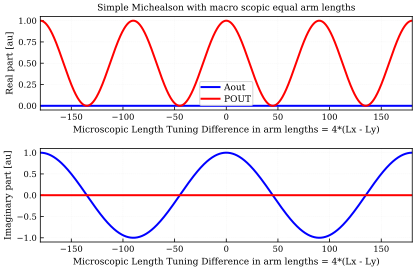

In [2]:
basekat=finesse.kat() # initialising Finesse
basekat.verbose = False
basecode = """
l laser 1 0 0 n0    # Laser (Power = 1 W, wavelength offset = 0, init phase = 0)
s s-w 1 n0 n1       # Space (Length = 1 m)
bs bs1 0.5 0.5 0 45 n1 n2 n3 n4   # Beam splitter R = 0.5, T = 0.5, 
                                  #  phi = 0, AoI = 45
s s-n 1000 n2 n5                  # Space 1000m Ly 
m1 ETMY 5e-06 3.75e-05 0 n5 dump  # Mirror_y R = 1, T = 0, phi = 0           
s s-e 1000 n3 n6                  # Space 1000m Lx
m1 ETMX 5e-06 3.75e-05 0 n6 dump               # Mirror_x R = 1, T = 0, phi = 0
"""
basekat.parse(basecode) # Parsing the FINESSE-code
detector_code = '''
pd0 POUT n4         # Power Output at Asymmetric Port 
ad Aout 0 n4        # Ampitude Detector at Asymmetric port
'''
simulation_code = '''
xaxis ETMY phi lin -180 180 1000
yaxis re:im
put* ETMX phi $mx1
'''
kat1 = deepcopy(basekat)
kat1.parse(detector_code);
kat1.parse(simulation_code);
out1 = kat1.run()
#out1.title = "Simple Michealson with equal Arm Lengths"
out1.xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)"
out1.plot(title = "Simple Michealson with macro scopic equal arm lengths")

**Note** : From the above graphs we can see that dark fringe appears when micro scopic path length difference is $\delta L / \lambda = 0.5$

<a name='chap_2'></a>
## 2. Simple Michealson With Phase modulator

<a name='chap_2_1'></a>
### 2.1. Optimize demodulation phase such that differential arm length change appears only at Asymmetric Port Quadrature Signal.
Instead of varying the demodulator phase, space between EOM and beam splitter is varied.

In [3]:
#Kat code describing Simple Michealson with phase modulator 
basekat_pm=finesse.kat() # initialising Finesse
basecode_pm = """
l laser 1 0 n0                      # Laser (Power = 1 W, wavelength offset = 0)
s sw 1 n0 nn1                      # Space (Length = 1 m)
mod eom1 9M 0.45 1 pm nn1 nn2       # Eom mod freq = 3MHz Lamda Mod ~ 33.33m 
s seom 33 nn2 n1      # Space between the EOM and input to interferometer
                            # is adjust such that difference in path lengths is
                            # observed at Quadrature and common path length changes
                            # are observed as In Phase signals.
bs bs1 0.5 0.5 0 45 n1 n2 n3 n4     # Beam Splitter R = 0.5, T = 0.5, phi = 0, 
                                    # AoI = 45 
s sn 1000 n2 n5             # Space BS and Mirror Y (Length Ly = 1000m)
m1 ETMY 5e-06 3.75e-05 0 n5 dump         # Mirror Y (R = 1)
s se 1000 n3 n6             # Space BS and Mirror X (Length Lx = 1000m)
m1 ETMX 5e-06 3.75e-05 0 n6 dump         # Mirror X (R = 1)
"""
basekat_pm.parse(basecode_pm)

In [4]:
# Instead of tuning for appropriate phase of demodulator, space between EOM and BS
# is adjusted such that difference in imag part of sidebands is zero. At that point 
# Difference in path lengths will be observed only at Asymmetric Quadrature.
kat_Q_optimize = finesse.kat()
kat_Q_optimize.verbose = False;
kat_Q_optimize.parse(basecode_pm)
detector_code = '''
ad Aout_lower -9M n4
ad Aout_upper 9M n4
'''
simulation_code = '''
xaxis seom L lin 25 40 1000
yaxis re:im
noxaxis
'''
kat_Q_optimize.parse(detector_code);
kat_Q_optimize.parse(simulation_code);

# Function takes input for space between EOM and BS 
def f(L):
    kat_Q_optimize.seom.L = L;
    res = kat_Q_optimize.run();
    return (res['Aout_upper'] - res['Aout_lower']).imag

# Find the 'L' such that difference of imag part of side band is zero 
from scipy import optimize
sol = optimize.root_scalar(f, bracket=[25.0, 40.0], method='brentq')
print ("Space between EOM and BS = " + str(sol.root) + 
       " to get difference in arms lengths only at ASQ (Asymmetric Port Quadrature)")

# set distance between EOM and BS
seom_length = sol.root;

Space between EOM and BS = 31.926659777777765 to get difference in arms lengths only at ASQ (Asymmetric Port Quadrature)


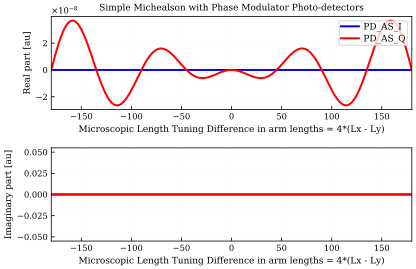

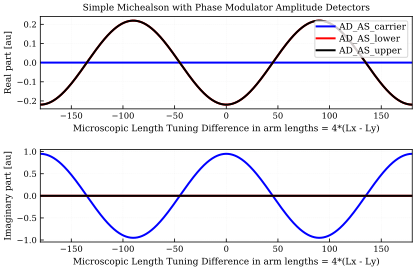

In [5]:
# Plots to show the amplitude of side bands and carrier, demodulated PD signals, 
# and carrier power vs variation of the microscopic differential length variation
# Note in these plots there is not variation of common mode length variation (Lx + Ly) 
kat1 = finesse.kat()
kat1.verbose = False
kat1.parse(basecode_pm) # Parsing the FINESSE-code
detector_code = '''
pd0 PD_AS n4             #Carrier Power at Asymmetric port
pd1 PD_AS_I 9M 0 n4      #Demodulated Asymmetric port In phase 
pd1 PD_AS_Q 9M 90 n4     #Demodulated Asymmetric port Quadrature
ad AD_AS_carrier 0 n4    #Carrier Amplitude at Asymmetric port 
ad AD_AS_lower -9M n4    #Lower Sideband Amplitude at Asymmetric port
ad AD_AS_upper 9M n4     #Upper Sideband Amplitude at Asymmetric port
'''
simulation_code = '''
xaxis ETMY phi lin -180 180 1000 #Mirror Y is varied -180 to 180 
put* ETMX phi $mx1               #Mirror X is varied 180 to 180
yaxis re:im
'''
kat1.seom.L = seom_length 
#delta_L = 0
#kat1.sn.L = 1000.0 - delta_L
#kat1.se.L = 1000.0 + delta_L
kat1.parse(detector_code);
kat1.parse(simulation_code);
out1 = kat1.run()
out1.plot(detectors = ['PD_AS_I', 'PD_AS_Q'], loc = 'upper right',
         title = "Simple Michealson with Phase Modulator Photo-detectors",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")
out1.plot(detectors = ['AD_AS_carrier', 'AD_AS_lower', 'AD_AS_upper'], loc = 'upper right',
         title = "Simple Michealson with Phase Modulator Amplitude Detectors",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")

<a name='chap_2_2'></a>
### 2.2 Optimize Schnupp Asymmetry for maximizing quadrature signal at asymmetric port.
In the above example, operating point of is at macroscopic length difference to zero. Below are examples with macroscopic asymmetry with different lengths.

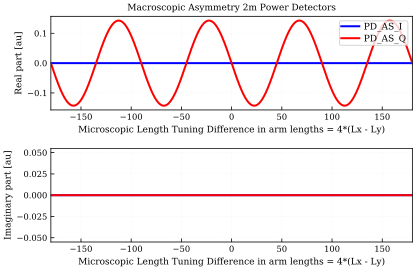

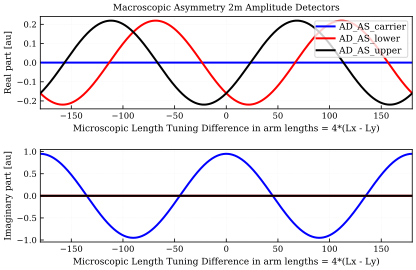

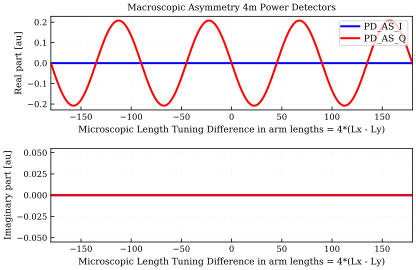

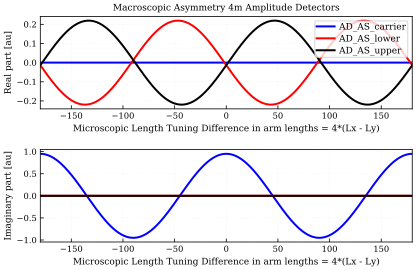

In [6]:
# Repeat the above with different macroscopic asymmetry settings.
kat2 = kat1.deepcopy()
delta_L = 2.0
kat2.sn.L = 1000.0 - delta_L
kat2.se.L = 1000.0 + delta_L
kat2.parse('yaxis re:im')
out2 = kat2.run()
out2.plot(detectors = ['PD_AS_I', 'PD_AS_Q'], loc = 'upper right',
         title = "Macroscopic Asymmetry 2m Power Detectors",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")
out2.plot(detectors = ['AD_AS_carrier', 'AD_AS_lower', 'AD_AS_upper'], loc = 'upper right',
         title = "Macroscopic Asymmetry 2m Amplitude Detectors",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")
kat3 = kat1.deepcopy()
delta_L = 4.0
kat3.sn.L = 1000.0 - delta_L
kat3.se.L = 1000.0 + delta_L
kat3.parse('yaxis re:im')
out3 = kat3.run()
out3.plot(detectors = ['PD_AS_I', 'PD_AS_Q'], loc = 'upper right',
         title = "Macroscopic Asymmetry 4m Power Detectors",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")
out3.plot(detectors = ['AD_AS_carrier', 'AD_AS_lower', 'AD_AS_upper'], loc = 'upper right',
         title = "Macroscopic Asymmetry 4m Amplitude Detectors",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")

In the above plots observe the sidebands amplitude at zero crossing of the carrier, that is dark fringe for the carrier. We also see the increase in PD_AS_Q (demodulated quadrature signal at asymmetric port), due to the asymmetry. Figure below, is the plot of PD_AS_Q signal at various asymmetries.  

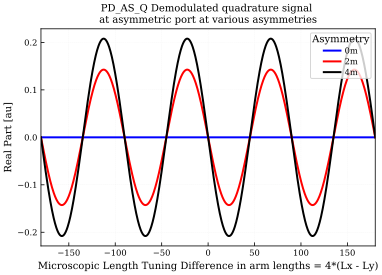

In [7]:
# Plot Showing PD_AS_Q at various arm length asymmetries. 
fig, ax = plt.subplots() 
ax.plot(out1.x, out1['PD_AS_Q'].real, label = "0m")  
ax.plot(out2.x, out2['PD_AS_Q'].real, label = "2m")  
ax.plot(out3.x, out3['PD_AS_Q'].real, label = "4m") 
ax.set_xlabel('Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)')
ax.set_ylabel('Real Part [au]')  
ax.set_title("PD_AS_Q Demodulated quadrature signal \n \
at asymmetric port at various asymmetries ")  
ax.legend(title = "Asymmetry", loc = 'upper right')  # Add a legend.
plt.show()

Optimize schnupp asymmetry for maximizing  quadrature signal at asymmetric port for simple michealson with phase modulator. Find asymmetry such that signal peak to peak is maximum.

In [8]:
# Optimize asymmetry for maximizing PD_AS_Q
kat4 = finesse.kat()
kat4.verbose = False
kat4.parse(basecode_pm)
kat4.seom.L = seom_length
detector_code = '''
pd1 PD_AS_Q 9M 90 n4     #Demodulated Asymmetric port Quadrature
'''
simulation_code = '''
xaxis ETMY phi lin 0 90 10000 #Mirror Y is varied -180 to 180 
put* ETMX phi $mx1               #Mirror X is varied 180 to 180
yaxis re:im
'''
kat4.parse(detector_code)
kat4.parse(simulation_code)

def f(delta_L):
    kat4.sn.L = 1000.0 - delta_L
    kat4.se.L = 1000.0 + delta_L
    out4 = kat4.run()
    pk_to_pk = abs(max(out4['PD_AS_Q']) - 
                   min(out4['PD_AS_Q'])) #return peak to peak difference
    return -1.0 * pk_to_pk

from scipy import optimize
res = optimize.minimize_scalar(f,bounds = (0.0, 33))
schnupp_dL= res.x
print (res)
print ("Schnupp Asymmetry for Maximum PD_AS_Q = " + str(res.x))
print ("Modulation Wavelength PD_AS_Q = " + str(seom_length))

     fun: -0.416757433553912
    nfev: 24
     nit: 19
 success: True
       x: 4.1637838825209785
Schnupp Asymmetry for Maximum PD_AS_Q = 4.1637838825209785
Modulation Wavelength PD_AS_Q = 31.926659777777765


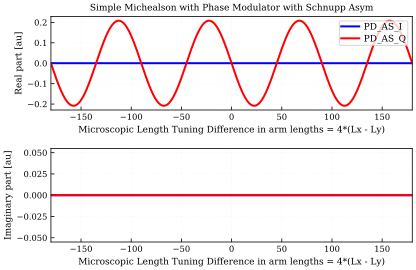

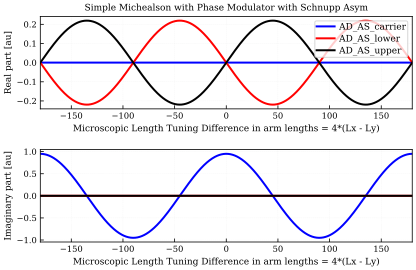

In [9]:
# plot the results with schnupp asymmetry
detector_code = '''
pd0 PD_AS n4             #Carrier Power at Asymmetric port
pd1 PD_AS_I 9M 0 n4      #Demodulated Asymmetric port In phase 
pd1 PD_AS_Q 9M 90 n4     #Demodulated Asymmetric port Quadrature
ad AD_AS_carrier 0 n4    #Carrier Amplitude at Asymmetric port 
ad AD_AS_lower -9M n4    #Lower Sideband Amplitude at Asymmetric port
ad AD_AS_upper 9M n4     #Upper Sideband Amplitude at Asymmetric port
'''
simulation_code = '''
xaxis ETMY phi lin -180 180 1000 #Mirror Y is varied -180 to 180 
put* ETMX phi $mx1               #Mirror X is varied 180 to 180
yaxis re:im
'''
kat4.seom.L = seom_length 

delta_L = schnupp_dL
kat4.sn.L = 1000.0 - delta_L
kat4.se.L = 1000.0 + delta_L
kat4.parse(detector_code);
kat4.parse(simulation_code);
out4 = kat4.run()
out4.plot(detectors = ['PD_AS_I', 'PD_AS_Q'], loc = 'upper right',
         title = "Simple Michealson with Phase Modulator with Schnupp Asym",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")
out4.plot(detectors = ['AD_AS_carrier', 'AD_AS_lower', 'AD_AS_upper'], loc = 'upper right',
         title = "Simple Michealson with Phase Modulator with Schnupp Asym",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")

<a name='chap_3'></a>
## 3. Power recylced Michealson Interferometer

In [35]:
#Place the power recycling mirror such that recycling cavity is resonant with the sidebands.
#So, we need to optimized the space between PRM and BS such that recycling cavity resonant
#at the side band frequency
basekat_prm=finesse.kat() # initialising Finesse
basecode_prm = """
l laser 1 0 n0                     # Laser (Power = 1 W, wavelength offset = 0)
s sw 1 n0 nn1                      # Space (Length = 1 m)
#m1 prm 1e-1 8.5e-06 0 nn1 nn4
m prm 0.995 0.001 0 nn1 nn4     # power recycling mirror R = 0.8, T = 0.2, phi = 0 
                            # lossless
s sprm 40 nn4 n1            # Space between prm and bs which will be optimized
                            # for resonant sidebands.
bs bs1 0.5 0.5 0 45 n1 n2 n3 n4   # Beam Splitter R = 0.5, T = 0.5, phi = 0, 
                                  # AoI = 45 
s sn 1000 n2 n5                   # Space BS and Mirror Y (Length Ly = 1000m)
m1 ETMY 5e-06 3.75e-05 0 n5 dump  # Mirror Y (R ~ 1)
s se 1000 n3 n6                   # Space BS and Mirror X (Length Lx = 1000m)
m1 ETMX 5e-06 3.75e-05 90 n6 dump # Mirror X (R ~ 1)
"""
basekat_prm.parse(basecode_prm)

<a name='chap_3_1'></a>
### 3.1 Optimize PRC Length for sidebands to resonate

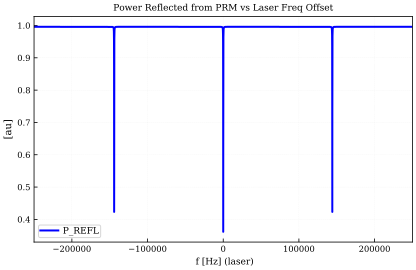

Resonant Frequency 0: -144150.0
Resonant Frequency 1: 0.0
Resonant Frequency 2: 144150.0
FSR = 144150.0


In [36]:
# Find the FSR of the cavity
kat1 = basekat_prm.deepcopy()
kat1.verbose = False
detector_code = '''
pd P_REFL nn1
'''
simulation_code = '''
xaxis laser f lin -250k 250k 10000
yaxis abs
'''
kat1.parse(detector_code);
kat1.parse(simulation_code);
out1 = kat1.run()
out1.plot(title = "Power Reflected from PRM vs Laser Freq Offset")

# From the graph we can see that there are three resonant frequencies in the
# laser frequency scan
res_freq_list = []
for i in range(0,3):
    array_power = out1["P_REFL"][int(len(out1["P_REFL"])*i/3):int(len(out1["P_REFL"])*(i+1)/3)]
    array_freq =  out1.x[int(len(out1["P_REFL"])*i/3):int(len(out1["P_REFL"])*(i+1)/3)]  
    min_array_power = min(array_power)
    index_min = list(array_power).index(min_array_power)
    res_peak_freq = array_freq[index_min]
    print ("Resonant Frequency " + str(i) + ": " + str(res_peak_freq))
    res_freq_list.append(res_peak_freq)
FSR_PRC = res_freq_list[-1] - res_freq_list[-2]
print ("FSR = " +  str(FSR_PRC))

In [37]:
#Optimize distance between PRM and BS such that sidebands are resonant 
#in the power recycling cavity
kat2 = basekat_prm.deepcopy()
kat2.verbose = False
detector_code = '''
pd P_REFL nn1
'''
side_band_freq = 9.0e6
upper_limit = side_band_freq + FSR_PRC/2
lower_limit = side_band_freq - FSR_PRC/2
simulation_code_xaxis = ("xaxis laser f lin " + 
                         str(lower_limit) + " " + 
                         str(upper_limit) + " 10000 \n")
simulation_code_yaxis = "yaxis abs"
kat2.parse(detector_code)
kat2.parse(simulation_code_xaxis)
kat2.parse(simulation_code_yaxis)

# Function for optimizing  space between PRM and BS 'L' such that side bands resonate
# This function returns difference between resonant frequecny at given 'L' and side band
# frequency.
def f(L):
    kat2.sprm.L = L;
    out2 = kat2.run();
    index_res_peak = list(out2['P_REFL']).index(min(out2['P_REFL']))
    res_peak_freq = out2.x[index_res_peak]
    #out2.plot()
    #print side_band_freq - res_peak_freq 
    return side_band_freq - res_peak_freq 

# Find root such that difference in resonant freqency and sideband frequency is zero
from scipy import optimize
sol = optimize.root_scalar(f, bracket=[10, 20], method='brentq')
Lp = sol.root
print ("Distance Between PRM and BS for sidebands to resonate = " + str(Lp))

Distance Between PRM and BS for sidebands to resonate = 15.963900442964851


In [13]:
# Plot above optimizing function f(L) vs  space between PRM and BS 'L'  
from pykat.external import progressbar
pbar = progressbar.ProgressBar().start()
x = np.arange(0,40,0.10);
y = []
pbar_index = 0
for i in x:
    pbar_index = int(i/x[-1]*100)
    pbar.update(pbar_index)
    y.append(f(i));
pbar.finish()

100% (100 of 100) |#######################| Elapsed Time: 0:01:10 Time: 0:01:10


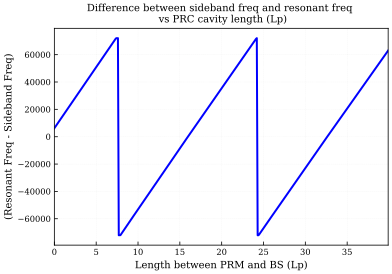

In [14]:
fig, ax = plt.subplots() 
ax.plot(x, y)  
ax.set_xlabel('Length between PRM and BS (Lp)')
ax.set_ylabel('(Resonant Freq - Sideband Freq)')  
ax.set_title("Difference between sideband freq and resonant \
freq \n vs PRC cavity length (Lp)")  
plt.show()

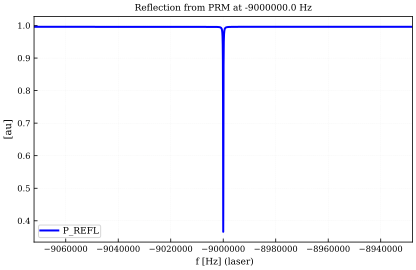

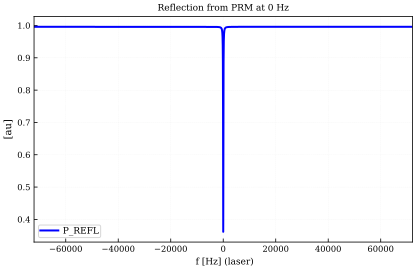

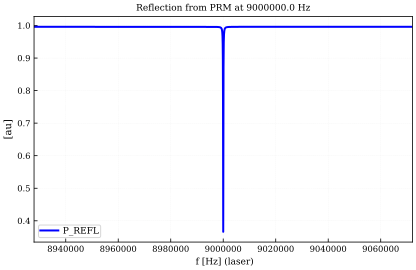

In [38]:
# Plot reflected power when freq offset is -9MHz, 0Hz, 9MHz to show that at above optimized
# length sideband and carrier are resonant
kat2 = basekat_prm.deepcopy()
kat2.verbose = False
detector_code = '''
pd P_REFL nn1
'''
kat2.sprm.L = Lp
freq_list = [-9e6, 0, 9e6]
for freq in freq_list:
    side_band_freq = freq
    upper_limit = side_band_freq + FSR_PRC/2
    lower_limit = side_band_freq - FSR_PRC/2
    simulation_code_xaxis = ("xaxis laser f lin " + 
                             str(lower_limit) + " " + 
                             str(upper_limit) + " 10000 \n")
    simulation_code_yaxis = "yaxis abs"
    kat2.parse(detector_code)
    kat2.parse(simulation_code_xaxis)
    kat2.parse(simulation_code_yaxis)
    out2 = kat2.run()
    out2.plot(title = "Reflection from PRM at " + str(freq) + " Hz")

<a name='chap_3_2'></a>
### 3.2 Optimize demodulation phase such that difference in arm length arrives at quadrature of asymmetric port

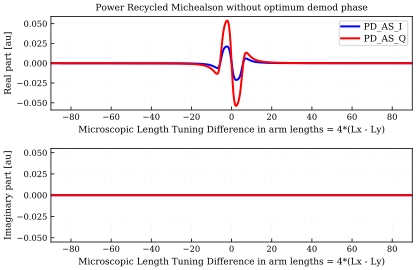

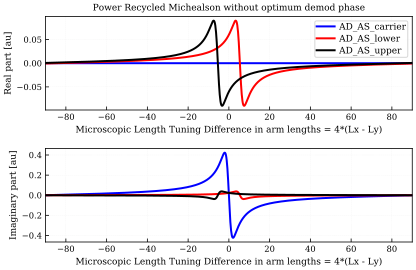

In [40]:
# Add eom to above setup and optimized the space between eom and PRM so that difference
# arm length signal is arrived only at quadrature of Asymmetric port (AS_Q)
#################################################################################
#Note: Mirror X (ETMX) inital phase phi = 90, which is dark for carrier.
#################################################################################
basekat_prm=finesse.kat() # initialising Finesse
basecode_prm = """
l laser 1 0 n0                     # Laser (Power = 1 W, wavelength offset = 0)
s sw 1 n0 nn1                      # Space (Length = 1 m)
mod eom1 9M 0.45 1 pm nn1 nn2       # Eom mod freq = 3MHz Lamda Mod ~ 33.33m 
s seom 33 nn2 nn3      # Space between the EOM and input to interferometer
                            # is adjust such that difference in path lengths is
                            # observed at Quadrature and common path length changes
                            # are observed as In Phase signals.
#m1 prm 0.03 8.5e-06 0 nn3 nn4
m prm 0.995 0.001 0 nn3 nn4     # power recycling mirror R = 0.8, T = 0.1, phi = 0 
                            # loss 0.1
s sprm 40 nn4 n1            # Space between prm and bs which will be optimized
                            # for resonant sidebands.
bs bs1 0.5 0.5 0 45 n1 n2 n3 n4     # Beam Splitter R = 0.5, T = 0.5, phi = 0, 
                                    # AoI = 45 
s sn 1000 n2 n5             # Space BS and Mirror Y (Length Ly = 1000m)
m1 ETMY 5e-06 3.75e-05 0 n5 dump         # Mirror Y (R = 1)
s se 1001 n3 n6             # Space BS and Mirror X (Length Lx = 1000m)
m1 ETMX 5e-06 3.75e-05 90 n6 dump         # Mirror X (R = 1)
"""
basekat_prm.parse(basecode_prm)
basekat_prm.sprm.L = Lp         # Set space between PRM and BS for sidebands to resonate.
kat1 = basekat_prm.deepcopy();
kat1.verbose = False
detector_code = '''
pd0 PD_AS n4             #Carrier Power at Asymmetric port
pd1 PD_AS_I 9M 0 n4      #Demodulated Asymmetric port In phase 
pd1 PD_AS_Q 9M 90 n4     #Demodulated Asymmetric port Quadrature
ad AD_AS_carrier 0 n4    #Carrier Amplitude at Asymmetric port 
ad AD_AS_lower -9M n4    #Lower Sideband Amplitude at Asymmetric port
ad AD_AS_upper 9M n4     #Upper Sideband Amplitude at Asymmetric port
'''
simulation_code = '''
xaxis ETMY phi lin -90 90 1000   #Mirror Y is varied -180 to 180 
put* ETMX phi $mx1               #Mirror X is varied 180 to 180
yaxis re:im
'''
kat1.seom.L = 1.2            #Some random space between EOM and PRM input
delta_L = 0.5                #Some random asymmetry to see the signals
kat1.sn.L = 1000.0 - delta_L
kat1.se.L = 1000.0 + delta_L
kat1.parse(detector_code);
kat1.parse(simulation_code);
out1 = kat1.run()
out1.plot(detectors = ['PD_AS_I', 'PD_AS_Q'], loc = 'upper right',
         title = "Power Recycled Michealson without optimum demod phase",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")
out1.plot(detectors = ['AD_AS_carrier','AD_AS_lower', 'AD_AS_upper'], loc = 'upper right',
         title = "Power Recycled Michealson without optimum demod phase",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")

In [41]:
# Instead of tuning for appropriate phase of demodulator, space between EOM and BS
# is adjusted such that slope of in phase component due to differential variation of arm
# lengths is minimized. 
kat_Q_optimize = basekat_prm.deepcopy()
kat_Q_optimize.verbose = False;
detector_code = '''
pd0 PD_AS n4             #Carrier Power at Asymmetric port
pd1 PD_AS_I 9M 0 n4      #Demodulated Asymmetric port In phase 
pd1 PD_AS_Q 9M 90 n4     #Demodulated Asymmetric port Quadrature
ad AD_AS_carrier 0 n4    #Carrier Amplitude at Asymmetric port 
ad AD_AS_lower -9M n4    #Lower Sideband Amplitude at Asymmetric port
ad AD_AS_upper 9M n4     #Upper Sideband Amplitude at Asymmetric port
'''
simulation_code = '''
xaxis ETMY phi lin -90 90 1000 #Mirror Y is varied -180 to 180 
put* ETMX phi $mx1               #Mirror X is varied 180 to 180
yaxis re:im
'''
kat_Q_optimize.parse(detector_code);
kat_Q_optimize.parse(simulation_code);
delta_L = 1.0   # Set some random asymmetry 
kat_Q_optimize.sn.L = 1000.0 - delta_L
kat_Q_optimize.se.L = 1000.0 + delta_L

# Function takes input for space between EOM and BS 
# and returns peak to peak value of the Inphase signal at
# asymmetric port.
def f(L):
    kat_Q_optimize.seom.L = L;
    res = kat_Q_optimize.run();
    #val = abs(min(res['PD_AS_I']) - max(res['PD_AS_I']))
    dy = np.diff(res['PD_AS_I'])
    dx = np.diff(res.x)
    slope = dy/dx
    val = slope[int(len(slope)/2)]
    #print val
    return abs(val)

# Find the 'L' such that difference of imag part of side band is zero 
from scipy import optimize
res = optimize.minimize_scalar(f,bounds = (0.1, 33), 
                               method = 'bounded')
print (res)
print ("Space between EOM and PRM = " + str(res.x) + 
       " to get difference in arms lengths singal only at ASQ (Asymmetric Port Quadrature)")

# set distance between EOM and BS
seom_length_prm = res.x;
#f(1.2)

     fun: 6.146386043932781e-09
 message: 'Solution found.'
    nfev: 22
  status: 0
 success: True
       x: 15.948179806740004
Space between EOM and PRM = 15.948179806740004 to get difference in arms lengths singal only at ASQ (Asymmetric Port Quadrature)


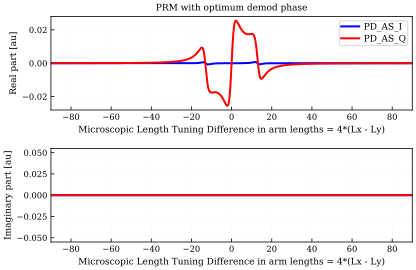

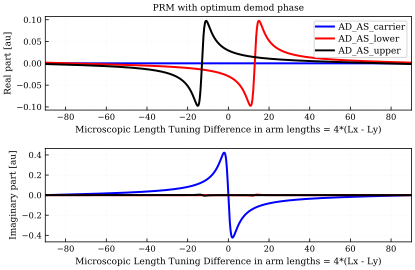

In [42]:
# In this plot at the optimized space between EOM and Assymetry port, Inphase signal
# at the asymmetry port is minimum
kat1 = basekat_prm.deepcopy();
kat1.verbose = False
detector_code = '''
pd0 PD_AS n4             #Carrier Power at Asymmetric port
pd1 PD_AS_I 9M 0 n4      #Demodulated Asymmetric port In phase 
pd1 PD_AS_Q 9M 90 n4     #Demodulated Asymmetric port Quadrature
ad AD_AS_carrier 0 n4    #Carrier Amplitude at Asymmetric port 
ad AD_AS_lower -9M n4    #Lower Sideband Amplitude at Asymmetric port
ad AD_AS_upper 9M n4     #Upper Sideband Amplitude at Asymmetric port
'''
simulation_code = '''
xaxis ETMY phi lin -90 90 1000 #Mirror Y is varied -180 to 180 
put* ETMX phi $mx1               #Mirror X is varied 180 to 180
yaxis re:im
'''
kat1.seom.L = seom_length_prm
delta_L = 1.2
kat1.sn.L = 1000.0 - delta_L
kat1.se.L = 1000.0 + delta_L
kat1.parse(detector_code);
kat1.parse(simulation_code);
out1 = kat1.run()
out1.plot(detectors = ['PD_AS_I','PD_AS_Q'], loc = 'upper right',
         title = "PRM with optimum demod phase",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")
out1.plot(detectors = ['AD_AS_carrier','AD_AS_lower', 'AD_AS_upper'], loc = 'upper right',
         title = "PRM with optimum demod phase",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")

<a name='chap_3_3'></a>
### 3.3 Optimize Schnupp asymmetry for a given R of PRM

In [43]:
# Optimize schnupp asymmetry for maximizing PD_AS_Q
basekat_prm.seom.L = seom_length_prm
kat4 = basekat_prm.deepcopy()
kat4.verbose = False
detector_code = '''
pd1 PD_AS_Q 9M 90 n4     #Demodulated Asymmetric port Quadrature
'''
simulation_code = '''
xaxis ETMY phi lin -90 90 100    #Mirror Y is varied -90 to 90 
put* ETMX phi $mx1               #Mirror X is varied 90 to -90
yaxis re:im
'''
kat4.parse(detector_code)
kat4.parse(simulation_code)

def f(delta_L):
    kat4.sn.L = 1000.0 - delta_L
    kat4.se.L = 1000.0 + delta_L
    out4 = kat4.run()
    dy = np.diff(out4['PD_AS_Q'].real)
    dx = np.diff(out4.x)
    slope = dy/dx
    val = -1.0 * abs(slope[int(len(slope)/2)]) #-1 is multiplied so that existing minimize
                                          # can be used  
    return val

from scipy import optimize
res = optimize.minimize_scalar(f,bounds = (0, 33))
schnupp_dL_prm= res.x
print (res)
print ("Asymmetry for Maximum PD_AS_Q = " + str(res.x))
print ("Modulation Wavelength PD_AS_Q = " + str(seom_length_prm))

     fun: -0.037596266929034484
    nfev: 22
     nit: 18
 success: True
       x: 0.32677948064080414
Asymmetry for Maximum PD_AS_Q = 0.32677948064080414
Modulation Wavelength PD_AS_Q = 15.948179806740004


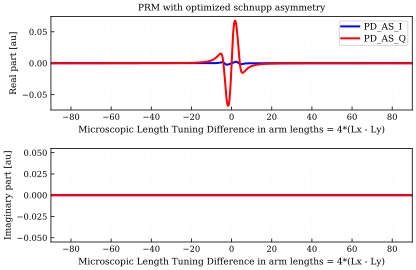

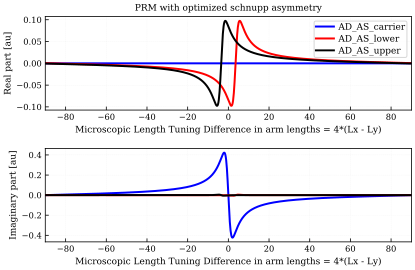

In [44]:
# In this plot PD_AS_I signal at optimized schnupp asymmetry for power recylced cavity
kat1 = basekat_prm.deepcopy();
kat1.verbose = False
detector_code = '''
pd0 PD_AS n4             #Carrier Power at Asymmetric port
pd1 PD_AS_I 9M 0 n4      #Demodulated Asymmetric port In phase 
pd1 PD_AS_Q 9M 90 n4     #Demodulated Asymmetric port Quadrature
ad AD_AS_carrier 0 n4    #Carrier Amplitude at Asymmetric port 
ad AD_AS_lower -9M n4    #Lower Sideband Amplitude at Asymmetric port
ad AD_AS_upper 9M n4     #Upper Sideband Amplitude at Asymmetric port
'''
simulation_code = '''
xaxis ETMY phi lin -90 90 1000   #Mirror Y is varied -90 to 90 
put* ETMX phi $mx1               #Mirror X is varied  90 to -90
yaxis re:im
'''
delta_L = schnupp_dL_prm
kat1.sn.L = 1000.0 - delta_L
kat1.se.L = 1000.0 + delta_L
kat1.parse(detector_code);
kat1.parse(simulation_code);
out1 = kat1.run()
out1.plot(detectors = ['PD_AS_I','PD_AS_Q'], loc = 'upper right',
         title = "PRM with optimized schnupp asymmetry",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")
out1.plot(detectors = ['AD_AS_carrier','AD_AS_lower', 'AD_AS_upper'], loc = 'upper right',
         title = "PRM with optimized schnupp asymmetry",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")

In [21]:
# 3D surface plot by X = R of PRM, Y = Schnupp Asymmetry, Z = Sensitivty of ASQ for 
# interferometer working at dark fringe for the carrier
PRM_R_arr = np.arange(0.96, 1.0 - 8.5e-06, 0.0005)
PRM_T_arr = 1.0 - PRM_R_arr - 8.5e-06
delta_L_arr = np.arange(0,2,0.01)
def func(PRM_R_arr, delta_L_arr):
    val = []
    from pykat.external import progressbar
    pbar = progressbar.ProgressBar(maxval = len(PRM_R_arr)).start()
    for i in range(len(PRM_R_arr)):
        #print str(i) + "/" + str(len(PRM_R_arr))
        pbar.update(i)
        kat4.prm.R = PRM_R_arr[i];
        kat4.prm.T = 1.0 - PRM_R_arr[i] - 8.5e-06 
        kat4.sn.L = 1000.0 - delta_L_arr[i]
        kat4.se.L = 1000.0 + delta_L_arr[i]
        out4 = kat4.run()
        dy = np.diff(out4['PD_AS_Q'].real)
        dx = np.diff(out4.x)
        slope = dy/dx
        val.append(abs(slope[int(len(slope)/2)]))
        #print('\b\b ' + str(i), end = '')
    pbar.finish()
    return np.array(val)
X = PRM_R_arr
Y = delta_L_arr
X, Y = np.meshgrid(X,Y)
zs = np.array(func(np.ravel(X), np.ravel(Y)))
Z = zs.reshape(X.shape)

100% (16000 of 16000) |###################| Elapsed Time: 0:06:18 Time: 0:06:18


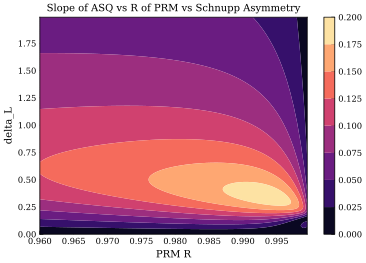

In [34]:
# 3D surface plot by X = R of PRM, Y = Schnupp Asymmetry, Z = Sensitivty of ASQ for 
# interferometer working at dark fringe for the carrier
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
fig = plt.figure()
ax = fig.add_subplot(111)
surf = ax.contourf(X, Y, Z)
ax.set_xlabel('PRM R')
ax.set_ylabel('delta_L')
#ax.set_zlabel('sens ASQ')
# Add a color bar which maps values to colors.
fig.colorbar(surf)
ax.set_title("Slope of ASQ vs R of PRM vs Schnupp Asymmetry")
plt.show()

<a name='chap_3_4'></a>
### 3.4 Optimize demodulation phase of REFL_I, REFL_Q
From the plots below, it can been seen that there is need to adjust the demodulation phase, DARM shall be seen only on REFL_I and CARM(PRCL) shall be seen only at REFL_Q.

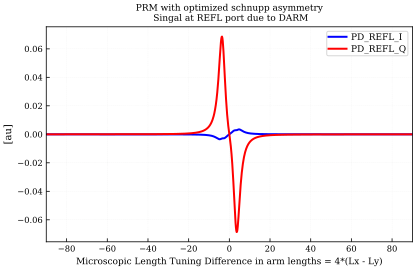

In [45]:
# Plot PD_REFL_Q, PD_REFL_I,
# vs differential microscopic arm movement(MICH) which is DARM in this example
kat1 = basekat_prm.deepcopy();
kat1.verbose = False
detector_code = '''
pd1 PD_AS_I 9M 0 n4      #Demodulated Asymmetric port In phase 
pd1 PD_AS_Q 9M 90 n4     #Demodulated Asymmetric port Quadrature
pd1 PD_REFL_I 9M 0 nn3
pd1 PD_REFL_Q 9M 90 nn3
pd1 PD_POP_I 9M 0 n1
pd1 PD_POP_Q 9M 90 n1
'''
simulation_code = '''
xaxis ETMY phi lin -90 90 1000   #Mirror Y is varied -90 to 90 
put* ETMX phi $mx1               #Mirror X is varied  90 to -90
yaxis abs
'''
delta_L = schnupp_dL_prm
kat1.sn.L = 1000.0 - delta_L
kat1.se.L = 1000.0 + delta_L
kat1.parse(detector_code);
kat1.parse(simulation_code);
out1 = kat1.run()
out1.plot(detectors = ['PD_REFL_I', 'PD_REFL_Q'], loc = 'upper right',
         title = "PRM with optimized schnupp asymmetry\n Singal at REFL port due to DARM",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")

In [46]:
# Find the current phase of the signal, and then offset it to demodulation phase
quad_sig = out1['PD_REFL_Q'][int(len(out1['PD_REFL_Q'])*0.52)]
in_sig = out1['PD_REFL_I'][int(len(out1['PD_REFL_I'])*0.52)]
phase = np.arctan(quad_sig/in_sig)
phase_deg =  phase*180.0/np.pi
print (phase_deg)
kat1.PD_REFL_I.phase1 = 90.0 + phase_deg
kat1.PD_REFL_Q.phase1 = phase_deg

-87.58494222608898


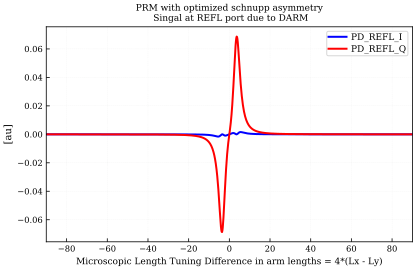

In [47]:
out1 = kat1.run()
out1.plot(detectors = ['PD_REFL_I', 'PD_REFL_Q'], loc = 'upper right',
         title = "PRM with optimized schnupp asymmetry\n Singal at REFL port due to DARM",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")

<a name='chap_3_5'></a>
### 3.5 Plots of all singals due to DARM (due to differential arm length change)

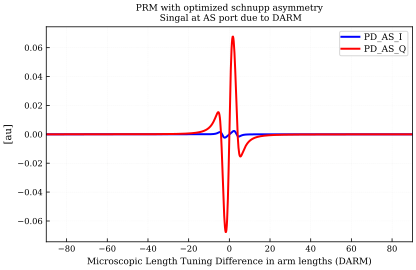

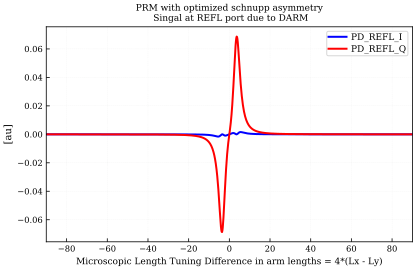

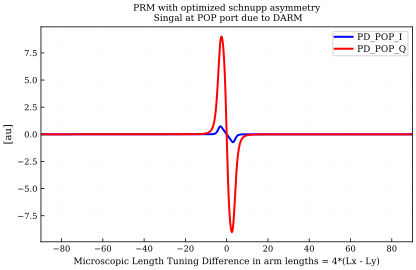

In [48]:
# Plot PD_AS_Q, PD_AS_I, PD_REFL_Q, PD_REFL_I, PD_POP_Q, PD_POP_I 
# vs differential microscopic arm movement(MICH) which is DARM in this example
simulation_code = '''
xaxis ETMY phi lin -90 90 1000   #Mirror Y is varied -90 to 90 
put* ETMX phi $mx1               #Mirror X is varied  90 to -90
yaxis abs
'''
kat1.parse(simulation_code);
out1 = kat1.run()
out1.plot(detectors = ['PD_AS_I','PD_AS_Q'], loc = 'upper right',
         title = "PRM with optimized schnupp asymmetry\n Singal at AS port due to DARM",
         xlabel = "Microscopic Length Tuning Difference in arm lengths (DARM)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")
out1.plot(detectors = ['PD_REFL_I', 'PD_REFL_Q'], loc = 'upper right',
         title = "PRM with optimized schnupp asymmetry\n Singal at REFL port due to DARM",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")
out1.plot(detectors = ['PD_POP_I', 'PD_POP_Q'], loc = 'upper right',
         title = "PRM with optimized schnupp asymmetry\n Singal at POP port due to DARM",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")

<a name='chap_3_6'></a>
### 3.6 Plots of all signals due to CARM (common mode arm length change)

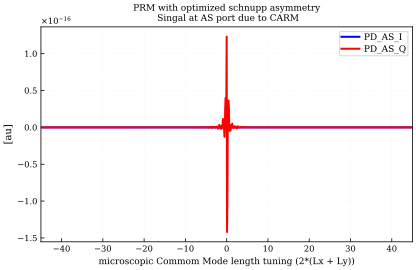

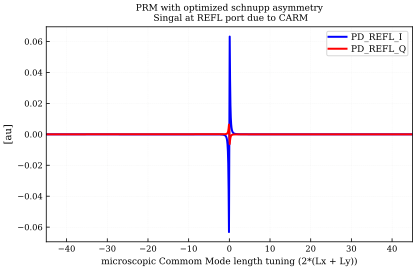

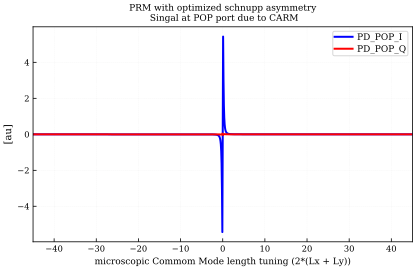

In [49]:
# Plot PD_AS_Q, PD_AS_I, PD_REFL_Q, PD_REFL_I, PD_POP_Q, PD_POP_I 
# vs commom microscopic arm movement(PRCL) which is CARM in this example
simulation_code = '''
xaxis ETMY phi lin -45 45 1000   #Mirror Y is varied -90 to 90 
put* ETMX phi $x1               #Mirror X is varied  90 to -90
yaxis abs
'''
kat2 = kat1.deepcopy()
kat2.parse(simulation_code);
out2 = kat2.run()
out2.plot(detectors = ['PD_AS_I','PD_AS_Q'], loc = 'upper right',
         title = "PRM with optimized schnupp asymmetry\n Singal at AS port due to CARM",
         xlabel = "microscopic Commom Mode length tuning (2*(Lx + Ly))")
out2.plot(detectors = ['PD_REFL_I', 'PD_REFL_Q'], loc = 'upper right',
         title = "PRM with optimized schnupp asymmetry\n Singal at REFL port due to CARM",
         xlabel = "microscopic Commom Mode length tuning (2*(Lx + Ly))")
out2.plot(detectors = ['PD_POP_I', 'PD_POP_Q'], loc = 'upper right',
         title = "PRM with optimized schnupp asymmetry\n Singal at POP port due to CARM",
         xlabel = "microscopic Commom Mode length tuning (2*(Lx + Ly))")

<a name='chap_3_7'></a>
### 3.7 Sensing Matrix for PRMI with single phase modulator
**Note :** Sensitivity is slope of the above singals i.e. $\frac{\Delta signal}{\Delta \phi}$, when the interferometer is operating at the dark fringe for carrier.

In [50]:
def find_sens(x, y):
    dx = np.diff(x);
    dy = np.diff(y);
    slope = dy/dx;
    return slope[int(len(slope)/2)]

In [51]:
sens_refl_i_darm = find_sens(out1.x, out1['PD_REFL_I'])
sens_refl_q_darm = find_sens(out1.x, out1['PD_REFL_Q'])
sens_pop_i_darm = find_sens(out1.x, out1['PD_POP_I'])
sens_pop_q_darm = find_sens(out1.x, out1['PD_POP_Q'])
sens_as_i_darm = find_sens(out1.x, out1['PD_AS_I'])
sens_as_q_darm = find_sens(out1.x, out1['PD_AS_Q'])

sens_refl_i_carm = find_sens(out2.x, out2['PD_REFL_I'])
sens_refl_q_carm = find_sens(out2.x, out2['PD_REFL_Q'])
sens_pop_i_carm = find_sens(out2.x, out2['PD_POP_I'])
sens_pop_q_carm = find_sens(out2.x, out2['PD_POP_Q'])
sens_as_i_carm = find_sens(out2.x, out2['PD_AS_I'])
sens_as_q_carm = find_sens(out2.x, out2['PD_AS_Q'])

In [52]:
index = ['CARM', 'DARM']
carm_list = (sens_refl_i_carm, sens_refl_q_carm,
             sens_pop_i_carm,  sens_pop_q_carm,
             sens_as_i_carm,   sens_as_q_carm)
darm_list = (sens_refl_i_darm, sens_refl_q_darm,
             sens_pop_i_darm,  sens_pop_q_darm,
             sens_as_i_darm,   sens_as_q_darm)

columns = ['REFL_I', 'REFL_Q', 'POP_I', 'POP_Q', 'AS_I', 'AS_Q']
df = pd.DataFrame([carm_list, darm_list],
                  index = index, columns = columns)
prettySensingMatrix(df)

,REFL_I,REFL_Q,POP_I,POP_Q,AS_I,AS_Q
CARM,0.702,-0.0699,60.4,-0.459,-5.88e-17,-2.94e-15
DARM,0.000516,0.0106,-0.274,-6.91,0.00129,0.0696


### TODO:
1. I think REFL_I signal due CARM should look like PDH, Need to find solution for it.
2. Need to add another 45MHz modulation to the above code. I think if i make 45MHz sidebands to resonate, and 9MHz sidebands not to resonate, then i probably get better CARM signal at REFL_I_9MHZ, and probably get error function shape like PDH error signal.
3. I should change the technique to find the correct deomodulation phase by checking the phase at a random point, and set that phase as offset in next simulation.

<a name='chap_3_8'></a>
### 3.8 Reflected and Circulating field amplitude variations due to CARM
The plots show that carrier and sidebands are resonating in the power recycled cavity formed between PRM and compound mirror (michelson interferometer). When operating the interferometer at dark fringe for the carrier, Compound mirror acts like perfectly reflecting mirror (except for the loss ETMx) for carrier. 

For maximizing the signal, we need to maximize power of carrier at beam splitter, so we need to make PRC to resonate for carrier. Power Recycled Cavity for carrier acts like overcavity. 

For maximizing modulation signal, we need to maximize the amplitude of the sidebands at the output. Inorder to get maximum singal at the output, PRC for sidebands should be like impedance matched cavity, where transmission of the compound mirror for sidebands is equal to transmission of PRM.  

I still dont understand why carrier should not resonate, and sidebands should resonate, for maximum sensitivity of ASQ signal.

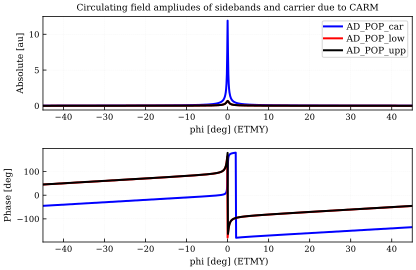

In [53]:
# Plot circulating electric field amplitudes of carrier and sidebands due to CARM
kat3 = kat2.deepcopy()
detector_code = '''
#pd1 PD_AS_I 9M 0 n4      #Demodulated Asymmetric port In phase 
#pd1 PD_AS_Q 9M 90 n4     #Demodulated Asymmetric port Quadrature
#pd1 PD_REFL_I 9M 0 nn3
#pd1 PD_REFL_Q 9M 90 nn3
#pd1 PD_POP_I 9M 0 n1
#pd1 PD_POP_Q 9M 90 n1
ad AD_POP_car 0 n1       # Amplitide detector placed at beam splitter n1 node
ad AD_POP_low -9M n1     # Amplitide detector placed at beam splitter n1 node
ad AD_POP_upp 9M n1      # Amplitide detector placed at beam splitter n1 node
'''
simulation_code = '''
xaxis ETMY phi lin -45 45 1000   #Mirror Y is varied -90 to 90 
put* ETMX phi $x1               #Mirror X is varied  90 to -90
yaxis abs:deg
'''
kat3.parse(detector_code)
kat3.parse(simulation_code)
out3 = kat3.run()
out3.plot(detectors = ['AD_POP_car', 'AD_POP_low', 'AD_POP_upp'],
         title = "Circulating field ampliudes of sidebands and carrier due to CARM")

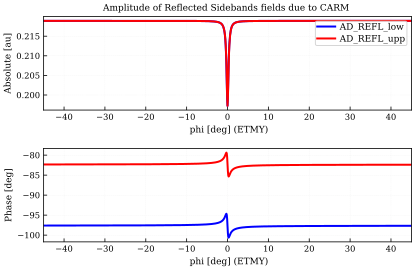

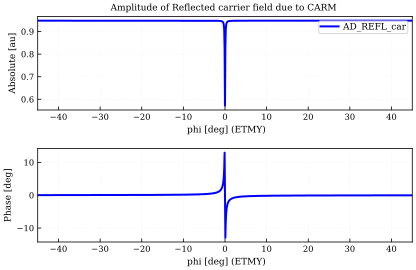

In [54]:
# Plot reflected field ampitudes of carrier and sideband due to CARM
kat3 = kat2.deepcopy()
detector_code = '''
#pd1 PD_AS_I 9M 0 n4      #Demodulated Asymmetric port In phase 
#pd1 PD_AS_Q 9M 90 n4     #Demodulated Asymmetric port Quadrature
#pd1 PD_REFL_I 9M 0 nn3
#pd1 PD_REFL_Q 9M 90 nn3
#pd1 PD_POP_I 9M 0 n1
#pd1 PD_POP_Q 9M 90 n1
ad AD_REFL_car 0 nn3     # Amplitde detector placed at reflection from PRM nn3 node
ad AD_REFL_low -9M nn3   # Amplitde detector placed at reflection from PRM nn3 node
ad AD_REFL_upp 9M nn3    # Amplitde detector placed at reflection from PRM nn3 node
'''
simulation_code = '''
xaxis ETMY phi lin -45 45 1000   #Mirror Y is varied -90 to 90 
put* ETMX phi $x1               #Mirror X is varied  90 to -90
yaxis abs:deg
'''
kat3.parse(detector_code)
kat3.parse(simulation_code)
out3 = kat3.run()
out3.plot(detectors = ['AD_REFL_low', 'AD_REFL_upp'],
         title = "Amplitude of Reflected Sidebands fields due to CARM ")
out3.plot(detectors = ['AD_REFL_car'],
         title = "Amplitude of Reflected carrier field due to CARM ")

### 4. Power Recycled Michealson 
This is another configuration where carrier is anti resonant and the sidebands are resonant.

In [21]:
#Place the power recycling mirror such that recycling cavity is resonant with the sidebands.
#So, we need to optimized the space between PRM and BS such that recycling cavity resonant
#at the side band frequency
basekat_prm_config2=finesse.kat() # initialising Finesse
basecode_prm_config2 = """
l laser 1 0 n0                     # Laser (Power = 1 W, wavelength offset = 0)
s sw 1 n0 nn1                      # Space (Length = 1 m)
mod eom1 9M 0.0 1 pm nn1 nn2       # Eom mod freq = 3MHz Lamda Mod ~ 33.33m 
s seom 33 nn2 nn3      # Space between the EOM and input to interferometer
                            # is adjust such that difference in path lengths is
                            # observed at Quadrature and common path length changes
                            # are observed as In Phase signals.
#m1 prm 0.03 8.5e-06 0 nn3 nn4
m prm 0.995 0.001 90 nn3 nn4     # power recycling mirror R = 0.8, T = 0.1, phi = 0 
s sprm 4 nn4 n1            # Space between prm and bs which will be optimized
                            # for resonant sidebands.
bs bs1 0.5 0.5 0 45 n1 n2 n3 n4   # Beam Splitter R = 0.5, T = 0.5, phi = 0, 
                                  # AoI = 45 
s sn 1000 n2 n5                   # Space BS and Mirror Y (Length Ly = 1000m)
m1 ETMY 5e-06 3.75e-05 0 n5 dump  # Mirror Y (R ~ 1)
s se 1000 n3 n6                   # Space BS and Mirror X (Length Lx = 1000m)
m1 ETMX 5e-06 3.75e-05 90 n6 dump # Mirror X (R ~ 1)
"""
basekat_prm_config2.parse(basecode_prm_config2)

### 4.1 Optimize PRC length such that sidebands resonate.

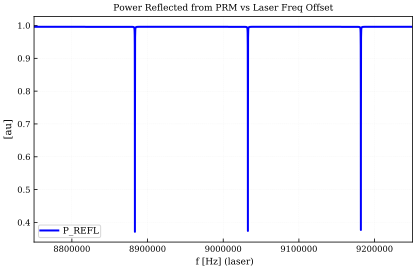

Resonant Frequency 0: 8874950.0
Resonant Frequency 1: 8883300.0
Resonant Frequency 2: 9032600.0
FSR = 149300.0


In [22]:
# Find the FSR of the cavity
kat1 = basekat_prm_config2.deepcopy()
kat1.verbose = False
detector_code = '''
pd P_REFL nn3
'''
side_band_freq = 9.0e6
upper_limit = side_band_freq + 250e3
lower_limit = side_band_freq - 250e3
simulation_code_xaxis = ("xaxis laser f lin " + 
                         str(lower_limit) + " " + 
                         str(upper_limit) + " 10000 \n")
simulation_code_yaxis = "yaxis abs"
kat1.parse(detector_code);
kat1.parse(simulation_code_xaxis);
kat1.parse(simulation_code_yaxis);
out1 = kat1.run()
out1.plot(title = "Power Reflected from PRM vs Laser Freq Offset")

# From the graph we can see that there are three resonant frequencies in the
# laser frequency scan
res_freq_list = []
for i in range(0,3):
    array_power = out1["P_REFL"][int(len(out1["P_REFL"])*i/4):int(len(out1["P_REFL"])*(i+1)/4)]
    array_freq =  out1.x[int(len(out1["P_REFL"])*i/4):int(len(out1["P_REFL"])*(i+1)/4)]  
    min_array_power = min(array_power)
    index_min = list(array_power).index(min_array_power)
    res_peak_freq = array_freq[index_min]
    print ("Resonant Frequency " + str(i) + ": " + str(res_peak_freq))
    res_freq_list.append(res_peak_freq)
FSR_PRC = res_freq_list[-1] - res_freq_list[-2]
print ("FSR = " +  str(FSR_PRC))

In [25]:
#Optimize distance between PRM and BS such that sidebands are resonant 
#in the power recycling cavity
kat2 = basekat_prm_config2.deepcopy()
kat2.verbose = False
detector_code = '''
pd P_REFL nn3
'''
side_band_freq = 9.0e6
upper_limit = side_band_freq + FSR_PRC/2
lower_limit = side_band_freq - FSR_PRC/2
simulation_code_xaxis = ("xaxis laser f lin " + 
                         str(lower_limit) + " " + 
                         str(upper_limit) + " 10000 \n")
simulation_code_yaxis = "yaxis abs"
kat2.parse(detector_code)
kat2.parse(simulation_code_xaxis)
kat2.parse(simulation_code_yaxis)

# Function for optimizing  space between PRM and BS 'L' such that side bands resonate
# This function returns difference between resonant frequecny at given 'L' and side band
# frequency.
def f(L):
    kat2.sprm.L = L;
    out2 = kat2.run();
    index_res_peak = list(out2['P_REFL']).index(min(out2['P_REFL']))
    res_peak_freq = out2.x[index_res_peak]
    #out2.plot()
    #print side_band_freq - res_peak_freq 
    return side_band_freq - res_peak_freq 

# Find root such that difference in resonant freqency and sideband frequency is zero
from scipy import optimize
sol = optimize.root_scalar(f, bracket=[0, 10], method='brentq')
Lp = sol.root
print ("Distance Between PRM and BS for sidebands to resonate = " + str(Lp))
basekat_prm_config2.sprm.L = Lp

Distance Between PRM and BS for sidebands to resonate = 7.635417362840774


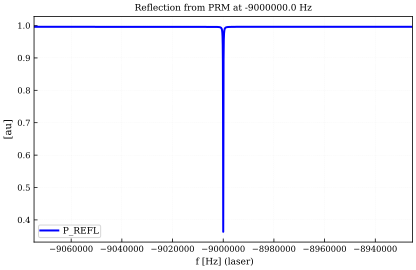

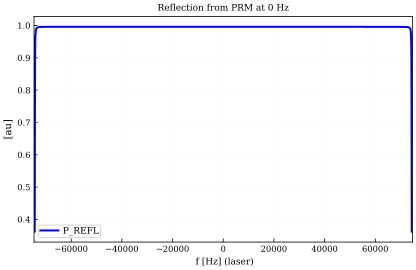

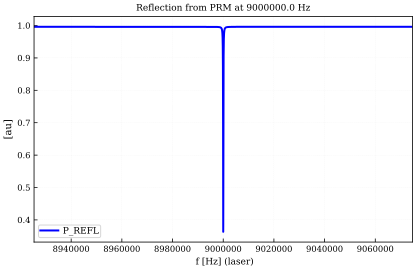

In [28]:
# Plot reflected power when freq offset is -9MHz, 0Hz, 9MHz to show that at above optimized
# length sideband and carrier are resonant
kat2 = basekat_prm_config2.deepcopy()
kat2.verbose = False
detector_code = '''
pd P_REFL nn3
#ad P_REFL 0 nn3
'''
#kat2.sprm.L = Lp
freq_list = [-9e6, 0, 9e6]
for freq in freq_list:
    side_band_freq = freq
    upper_limit = side_band_freq + FSR_PRC/2
    lower_limit = side_band_freq - FSR_PRC/2
    simulation_code_xaxis = ("xaxis laser f lin " + 
                             str(lower_limit) + " " + 
                             str(upper_limit) + " 10000 \n")
    simulation_code_yaxis = "yaxis abs"
    simulation_code_detector = "put P_REFL f $x1"
    kat2.parse(detector_code)
    kat2.parse(simulation_code_xaxis)
    kat2.parse(simulation_code_yaxis)
    out2 = kat2.run()
    out2.plot(title = "Reflection from PRM at " + str(freq) + " Hz")

--------------------------------------------------------------
Running kat - Started at 2020-06-01 14:04:44.748369
Used Finesse 2.3.1 at /usr/local/bin/kat

Finished in 0.061389 seconds


100% | ETA:  0:00:00 | Calculating                                             

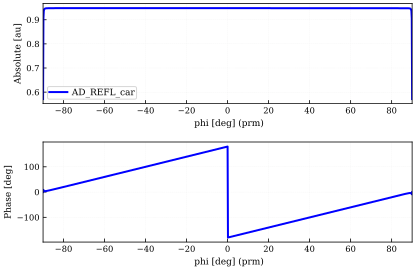

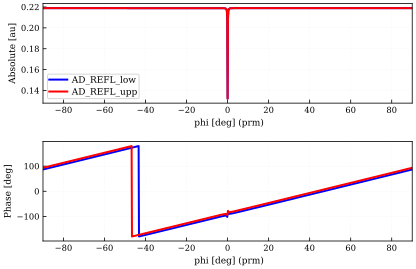

In [33]:
basekat_prm_config2.eom1.midx = 0.45
kat4 = basekat_prm_config2.deepcopy()
detector_code = '''
ad AD_REFL_car 0 nn3
ad AD_REFL_upp 9M nn3
ad AD_REFL_low -9M nn3
'''
simulation_code = '''
xaxis* prm phi lin -90 90 1000
yaxis abs:deg'''
kat4.parse(detector_code)
kat4.parse(simulation_code)
out4 = kat4.run()
out4.plot(detectors = ['AD_REFL_car'])
out4.plot(detectors = ['AD_REFL_upp', 'AD_REFL_low'])